# Clasificación binaria con redes neuronales, parte 1

En este taller, entrenaremos una red neuronal para la tarea de clasificación. Veremos cómo se entrena una red neuronal para esta tarea, cómo se ven las curvas de pérdida durante el entrenamiento y cómo afecta la elección de funciones de activación el desempeño de la red.

In [1]:
#Importamos las librerias necesarias
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np

In [2]:
#Una serie de funciones auxiliares utilizadas para visualizar nuestros resultados.
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    """
    Dibuja los límites de decisión del modelo al predecir en X en comparación con y.
    """
    # Pon todo en la CPU (funciona mejor con NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Configurar los límites de predicción y la cuadrícula
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Crear características
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Realizar predicciones
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Comprobar si es multiclase o binario y ajustar los logits a las etiquetas de predicción
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multiclase
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binario

    # Reformar predicciones y trazar
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=35, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

def plot_features_space(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    """
    Grafica el espacio de características generado por cada capa oculta del modelo..
    """
    # Pon todo en la CPU (funciona mejor con NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    X_pred = X

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Crear características
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Realizar predicciones
    model.eval()
    layers = dict(model.named_modules())
    layers.pop("")
    names_main = list(layers.keys())
    names = [i for i in names_main if "layer" in i]
    activation = [i for i in names_main if not "layer" in i]

    if len(activation) != 0:
      activation_layer = layers.pop(activation[0])

    fig, ax = plt.subplots(1,len(layers) + 1,layout="constrained",subplot_kw={"projection":"3d"},figsize=plt.figaspect(1/4))
    ax[0].remove()
    ax[0] = fig.add_subplot(1,len(layers) + 1,1)
    markers = ["o","^"]
    colors = ["blue","red"]
    for i in range(2):
      subset = X[np.where(y==i)]
      ax[0].scatter(subset[:,0],subset[:,1],marker=markers[i],label=f"Clase {i}",alpha=0.5,c=colors[i])

    ax[0].set(title="Original space",xlabel="$X_1$",ylabel="$X_2$")
    ax[0].legend()

    letters = ["Y","Z"]

    with torch.inference_mode():
      for i in range(len(layers)-1):
        X = layers[names[i]](X)
        if len(activation) != 0:
          X = activation_layer(X)
        for k in range(2):
          subset = X[np.where(y==k)]
          ax[i+1].scatter(subset[:,0],subset[:,1],subset[:,2],marker=markers[k],c=colors[k],label=f"Clase {k}",alpha=0.5)

        ax[i+1].set(title=f"Layer: {names[i]}",xlabel="${}_1$".format(letters[i]),ylabel="${}_2$".format(letters[i]))
        ax[i+1].legend()

    y_logits = model(X_pred)
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multiclase
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binario

    y_pred = y_pred.detach().numpy()
    ax[-1].remove()
    ax[-1] = fig.add_subplot(1,len(layers) + 1,4)
    for k in range(2):
        subset = X_pred[np.where(y==k)]
        ax[-1].scatter(subset[:,0],subset[:,1],marker=markers[k],c = colors[k],label=f"Clase {k}",alpha=0.9)

    y_logits_space = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred_space = torch.softmax(y_logits_space, dim=1).argmax(dim=1)  # multiclase
    else:
        y_pred_space = torch.round(torch.sigmoid(y_logits_space))  # binario

    # Reformar predicciones y trazar
    y_pred_space = y_pred_space.reshape(xx.shape).detach().numpy()
    ax[-1].contourf(xx, yy, y_pred_space, cmap=plt.cm.RdYlBu, alpha=0.6)
    ax[-1].set_xlim(xx.min(), xx.max())
    ax[-1].set_ylim(yy.min(), yy.max())
    ax[-1].set(title=f"Output",xlabel="$X_1$",ylabel="$X_2$")
    plt.show()


# Calcular la Exactitud (una métrica de clasificación)
def accuracy_fn(y_true, y_pred):
    """Calcula la Exactitud entre las etiquetas verdaderas y las predicciones.

    Args:
        y_true (torch.Tensor): Etiquetas verdaderas para las predicciones.
        y_pred (torch.Tensor): Predicciones a comparar con las etiquetas verdaderas.

    Devuelve:
        [torch.float]: Valor de Exactitud entre y_true y y_pred, p. ej., 78,45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


# Función para trazar curvas de pérdida de un modelo
def plot_loss_curves(results):
    """Trazar las curvas de entrenamiento de un diccionario de resultados.

    Args:
        results (dict): diccionario que contiene listas de valores, p. ej.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = np.array(torch.tensor(results["train_loss"]).cpu().numpy())
    test_loss = np.array(torch.tensor(results["test_loss"]).cpu().numpy())
    accuracy = np.array(torch.tensor(results["train_acc"]).cpu().numpy())
    test_accuracy = np.array(torch.tensor(results["test_acc"]).cpu().numpy())

    epochs = range(0,len(np.array(torch.tensor(results["train_loss"]).cpu().numpy()))*10,10)

    plt.figure(figsize=(15, 7))

    # Trazar la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Pérdida de entrenamiento")
    plt.plot(epochs, test_loss, label="Pérdida de prueba")
    plt.title("Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Función de pérdida")
    plt.legend()

    # Trazar la Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Exactitud de entrenamiento")
    plt.plot(epochs, test_accuracy, label="Exactitud de prueba")
    plt.title("Exactitud")
    plt.xlabel("Época")
    plt.ylabel("Exactitud (%)")
    plt.legend()
    plt.show()

def set_seeds(seed: int=0):
    """Establece las semillas aleatorias para operaciones en torch.

    Args:
        seed (int, opcional): Semilla aleatoria para establecer. Valor predeterminado: 42.
    """
    # Establece la semilla para operaciones generales en torch
    torch.manual_seed(seed)
    # Establece la semilla para operaciones en CUDA torch (las que ocurren en la GPU)
    torch.cuda.manual_seed(seed)

def final_test_accuracy(results):
    """Retorna el último valor de Exactitud en el conjunto de prueba.

    Args:
        results (dict): diccionario que contiene listas de valores, p. ej.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    test_accuracy = np.array(torch.tensor(results["test_acc"]).cpu().numpy())
    return test_accuracy[-1]


## 1.0 Generación y preparación de los datos

Ahora, genereraremos y visualizaremos los datos que queremos clasificar.

In [3]:
#Vamos a generar 1000 datos
n_samples=1000
#La libreria sklearn nos permite generar datos con diferentes distribuciones, clases y en diferentes dimensiones.
X,y=make_gaussian_quantiles(mean=None, cov=10, n_samples=1000, n_features=2, n_classes=2, shuffle=False, random_state=0)

Resolveremos el problema de clasificación binaria. Como veremos en la siguiente tabla, tendremos datos en dos dimensiones. Cada dato es de la forma $(x_{1},x_{2})$ y cada dato tiene una etiqueta (label) de 0 o 1. Estas serán nuestras dos clases que queremos clasificar.

In [4]:
#Creamos un dataframe con nuestros datos.
moons=pd.DataFrame({'X1':X[:,0]
                      ,'X2': X[:,1],
                      'label':y})
#En la siguiente tabla se muestran los primeros 5 datos de nuestra base de datos.
moons.head(5)

,X1,X2,label
0,-0.035246,0.036363,0
1,0.069119,0.134520,0
2,0.096597,-0.116636,0
3,-0.177508,-0.004380,0
4,0.213429,0.051666,0


En la siguiente figura, podemos visualizar nuestros datos. Lo datos azules representan la clase del 0 y los puntos rojos representan la clase del 1.

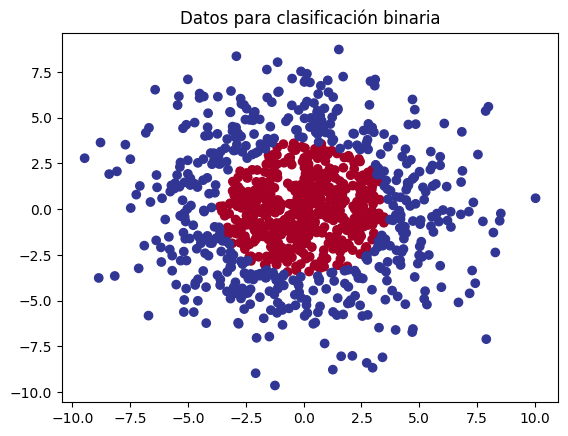

In [5]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.title('Datos para clasificación binaria')
plt.show()

In [6]:
#Convertimos nuestros datos en tensores
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

Recuerde que para entrenar un modelo de aprendizaje profundo debemos separar nuestra base de datos en tres conjuntos: datos de entrenamiento, datos de validación y datos de prueba. En este taller únicamente lo separaremos en los conjuntos de prueba y de entrenamiento.

In [7]:
#Esta función separa los datos en los conjuntos de entrenamiento y prueba. Escoge los conjuntos de forma aleatoria.
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y,
                                                   test_size=0.2, #20% de nuestros datos serán
                                                   #de prueba y el otro 80% serán de entrenamiento
                                                   random_state=0)

## 2.0 Construcción del modelo de clasificación

**IMPORTANTE!** Recuerde que entrenar una red neuronal profunda es una tarea costosa computacionalmente. Para acelerar nuestro proceso de entrenamiento debemos utilizar una GPU en vez de la CPU.

Las GPUs, o Unidades de Procesamiento Gráfico, desempeñan un papel crucial en la inteligencia artificial debido a su capacidad para realizar una gran cantidad de cálculos simultáneamente, lo que se conoce como procesamiento paralelo. Esta característica las hace ideales para tareas intensivas en cálculos, como el entrenamiento de redes neuronales en el aprendizaje profundo. A diferencia de las CPU tradicionales, que están diseñadas para realizar cálculos secuenciales, las GPUs están optimizadas para ejecutar múltiples tareas en paralelo, lo que acelera significativamente el proceso de entrenamiento de modelos de IA y reduce el tiempo requerido. Esta capacidad de procesamiento masivo las convierte en el corazón de la IA actual, permitiendo avances significativos en campos como el procesamiento de lenguaje natural, la visión por computadora y más.

En la siguiente celda confirmaremos que estamos trabajando en la GPU.

In [8]:
#Nos aseguramos de estar trabajando con la GPU. Si esta imprime 'cuda' significa que estamos trabajando con una GPU.
#De lo contrario, imprimirá 'cpu'.
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 2.1 Arquitectura de la red

Para crear nuestra red neuronal y entrenarla utilizaremos una libreria llamada **PyTorch.**

PyTorch es un marco de aprendizaje automático de código abierto basado en el lenguaje de programación Python y la biblioteca Torch. Se trata de una herramienta de código abierto utilizada para la creación y entrenamiento de modelos de Deep Learning. PyTorch está diseñado para acelerar el proceso desde la prototipación de investigación hasta la implementación en producción, y se ha convertido en una elección popular en la comunidad de aprendizaje profundo.

Fue desarrollado inicialmente por el laboratorio de investigación de inteligencia artificial de Facebook (FAIR), que ahora se conoce como Meta. PyTorch se basa en Python, lo que lo hace compatible con bibliotecas populares como NumPy, SciPy y otras. Esta flexibilidad y facilidad de uso hacen que PyTorch sea una elección preferida para la investigación y la creación rápida de prototipos en el campo del aprendizaje profundo, en contraste con TensorFlow, que es otra libreria popular para el entrenamiento de redes neuronales que tiende a ser más estático y orientado a la producción, lo que puede requerir una curva de aprendizaje más pronunciada.

Ahora, crearemos nuestra red neuronal.

In [9]:
#Crearemos un modelo que instancia la clase nn de PyTorch (nn de Neural Network)
class ClassifierModelV0(nn.Module):
  def __init__(self):
    #Inicializamos la clase
    super().__init__()

    # Creamos 3 capas donde todas las neuronas tienen función de activación lineal (nn.Linear).
    #Note que el tamaño de la primera capa 'in_features' es 2, pues nuestros datos de entrada
    #están en 2 dimensiones. La salida de nuestro modelo tiene dimensión 1, pues queremos resolver
    #un problema de clasificación binaria.

    #La función nn.Sequential crea un objeto secuencial donde la salida de una capa, se convierte
    #en la entrada de la siguiente capa. Esto es importante, pues cada objeto nn.Linear crea
    #una capa de nuestra red con función de activación lineal. La primera capa nn.Linear tiene
    #2 valores de entrada y 3 de salida. Esto significa que nuestra segunda capa tiene 3 neuronas.

    #La segunda capa tiene como parámetros in_features=3 y out_features=3. Esto significa que estamos creando
    #una capa totalmente conectada de 3 neuronas.

    #En este modelo tendremos dos capas ocultas de 3 neuronas cada una.
    self.layer_1=nn.Linear(in_features=2, out_features=3)
    self.layer_2=nn.Linear(in_features=3,out_features=3)
    self.layer_3=nn.Linear(in_features=3,out_features=1)



  #Esta función define un paso forward de nuestra red. Es decir, la salida de la red dado un dato de entrada.
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


#Creamos una instancia de nuestro primer modelo y le decimos que todo se procese en la GPU.
model_0=ClassifierModelV0().to(device)
#Con este comando podemos ver un breve resumen de la arquitectura de nuestro modelo. El parámetro=True
#nos indica que en cada capa estamos añadiendo sesgos.
model_0


ClassifierModelV0(
  (layer_1): Linear(in_features=2, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=3, bias=True)
  (layer_3): Linear(in_features=3, out_features=1, bias=True)
)

Con la siguiente función podemos ver qué tan compleja es nuestra red. Como se puede ver, tenemos una red no muy profunda con solo 2 capas ocultas. El comando state_dict() nos muestra todos los parámetros actuales de nuestra red. Inicialmente estos parámetros se inicializan de forma aleatoria y luego se irán ajustando durante el entrenamiento.

In [10]:
#Veamos cuántos parámetros tiene nuestro modelo
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3117, -0.5517],
                      [-0.6415, -0.5211],
                      [ 0.5257,  0.0754]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.5139, -0.2990,  0.1775], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0484, -0.0976,  0.1652],
                      [ 0.3871, -0.1797, -0.2143],
                      [-0.3593, -0.2081,  0.4044]], device='cuda:0')),
             ('layer_2.bias',
              tensor([0.0931, 0.0975, 0.3492], device='cuda:0')),
             ('layer_3.weight',
              tensor([[ 0.2330, -0.3914, -0.4036]], device='cuda:0')),
             ('layer_3.bias', tensor([-0.0277], device='cuda:0'))])

### 2.2 Función de pérdida y optimizador

Recuerde que para entrenar una red neuronal necesitamos definiar una función de pérdida. En este caso, como estamos solucionando un problema de clasificación binaria utilizaremos la función de Binary Cross Entropy. Esta es solo una de las multiples funciones de pérdida que ofrece la libreria torch.nn. Puede consultar en la siguiente página más funciones de pérdida: [Documentación de la librería nn de PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions).

También debemos definir los hiperparámetros necesarios para entrenar nuestro modelo. En este caso, utilizaremos un algoritmo conocido como descenso del gradiente estocástico. Este algoritmo es una variación del algoritmo de descenso de gradiente y su hiperparámetro más importante es la tasa de aprendizaje, que en este caso se denota 'lr' por learning rate. En la siguiente página podrá encontrar cómo escoger más parámetros del optimizador así como una gran variedad de optimizadores. [Documentación de la librería nn de PyTorch](https://pytorch.org/docs/stable/optim.html).

In [11]:
#Definición de la función de pérdida
loss_fn=nn.BCEWithLogitsLoss()
#Definimos el optimizador (stochastic gradient descent) y definimos la tasa de aprendizaje lr
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

## 2.3 Métricas de entrenamiento

Ahora vamos a establecer una métrica para evaluar cómo está funcionando nuestra red durante el entrenamiento. En este caso, elegimos usar la exactitud (accuracy), que básicamente nos dice qué tan bien está acertando nuestra red en comparación con el total de predicciones que hace. Idealmente, queremos que este número se acerque a 1, lo que significa que nuestra red está acertando el 100% de las veces.

Durante el entrenamiento, vamos a hacer un gráfico para ver cómo cambia esta métrica. Esto nos dará información útil sobre cómo está progresando el entrenamiento y nos ayudará a identificar qué ajustes podemos hacer para que nuestra red aprenda mejor.

Hay muchos tipos de métricas de entrenamiento que se adaptan mejor a diferentes tipos de problemas de aprendizaje profundo.

In [12]:
#Esta función conocida como accuracy nos dará una medida de qué tan bien está clasificando nuestra red.
#Esta métrica es simplemente el porcentaje de clasificaciones correctas que ha hecho el modelo sobre el total de predicciones
#realizadas.
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

## 3.0 Entrenamiento y validación de nuestra red neuronal

Ahora, debemos entrenar nuestra red neuronal. Acá, aplicaremos todos los pasos de entrenamiento que hemos visto durante el curso:



1.   Inicializamos los parámetros de la red de forma aleatoria. Esto se hizo en el momento que creamos nuestra red neuronal.
2.   Hacemos un paso forward con los datos de entrenamiento. Es decir, calculamos la salida de la red para un dato de entrenamiento (o para un batch de datos).
3. Calculamos la pérdida de cada dato (o de cada batch de datos) utilizando la función de pérdida.
4. Utilizamos el algoritmo de retropropagación para aproximar el gradiente de la pérdida con respecto a los parámetros de la red.
5. Utilizamos el algoritmo de descenso de gradiente estocástico para actualizar los pesos de la red.
6. Graficamos las curvas de pérdida para los datos de entrenamiento y de prueba para evaluar el aprendizaje de nuestro modelo.
7. Repetimos estos pasos hasta obtener una pérdida pequeña o hasta que nuestras métricas de desempeño estén cerca a 1. En este ejemplo calcularemos la precisión del modelo.
8. Cuando obtengamos una pérdida o precisión deseable, detenemos el entrenamiento.







En la siguiente celda ejecutamos en código lo que está descrito en palabras en la celda anterior. Es decir, al ejecutar esta celda estaríamos entrenando nuestra red para un número de épocas deseadas y dados unos hiperpárametros fijos.

In [13]:
#Fijamos una semilla aleatoria para que nuestros resultados sean reproducibles.
torch.manual_seed(0)
torch.cuda.manual_seed(0)
#Por cuántas épocas queremos entrenar.
epochs=100

#Guardamos diferentes valores para luego graficarlos. Guardaremos las épocas
#y la pérdida y precisión de prueba y entrenamiento.
epoch_count=[]
loss_values=[]
test_loss_values=[]
train_acc_values=[]
test_acc_values=[]

#Le decimos que haga los cálculos en la GPU.
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

#Iteramos en cada época.
for epoch in range(epochs):
  #Le decimos al modelo que se ponga en 'modo de entrenamiento'.
  model_0.train()

  #2.Hacemos un paso forwarad.
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #3. Calculamos la pérdida y la precisión de nuestro modelo para los datos para los que hicimos
  #el paso forward en el paso 2.
  loss=loss_fn(y_logits, y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  #Esta función 'reinicia' los gradientes. Se utiliza cuando estamos entrenando por batches de datos y tenemos
  #memoria limitada. PyTorch per defecto acumula los gradientes de un batch y cuando pasamos de un batch a otro,
  #debemos reiniciar el gradiente.
  optimizer.zero_grad()

  #4. Utilizamos el algoritmo de retropropagación para estimar el gradiente de la pérdida.
  loss.backward()

  #5. Utilizamos el algoritmo de descenso del gradiente estocástico para actualizar los pesos de nuestra
  #red.
  optimizer.step()

  #6. Probamos el modelo con los pesos actualizados en el conjunto de prueba. Guardamos estos valores para irlos
  #graficando y poder evaluar si nuestra red está aprendiendo.

  #Le decimos al modelo que se ponga en 'modo de evaluación'.
  model_0.eval()
  with torch.inference_mode():

    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    #Calculamos la pérdida y la precisión en el conjunto de prueba
    test_loss=loss_fn(test_pred, y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)


#Vamos a guardar los resultados cada 10 épocas para luego graficarlos.
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
#Guardamos los resultados del entrenamiento para luego graficarlos.
results={"train_loss": loss_values,
             "train_acc": train_acc_values,
             "test_loss": test_loss_values,
             "test_acc":test_acc_values}


## 3.1 Validación de nuestra red neuronal

En la siguiente celda, vamos a generar algunas *curvas de entrenamiento*. En la primera figura, se representa la evolución de la pérdida de nuestra red a lo largo de las épocas de entrenamiento. Es importante recordar que nuestro objetivo es que tanto la pérdida de entrenamiento como la de prueba disminuyan. Si la curva de pérdida de entrenamiento desciende, esto indica que nuestro modelo está aprendiendo a clasificar los datos de entrenamiento. Sin embargo, lo más relevante es que la curva de pérdida de los datos de prueba disminuya, ya que estos son datos que el modelo **no ha visto previamente**. Si esta curva desciende, significa que nuestro modelo está aprendiendo a clasificar correctamente datos nuevos con los que no ha sido previamente entrenado. Este es nuestro objetivo principal.

En la segunda figura, presentamos las curvas de precisión. Nuestra meta es que estas curvas se aproximen a 1 a lo largo de las épocas, ya que el valor de estas curvas nos proporciona la proporción de clasificaciones correctas realizadas por el modelo.

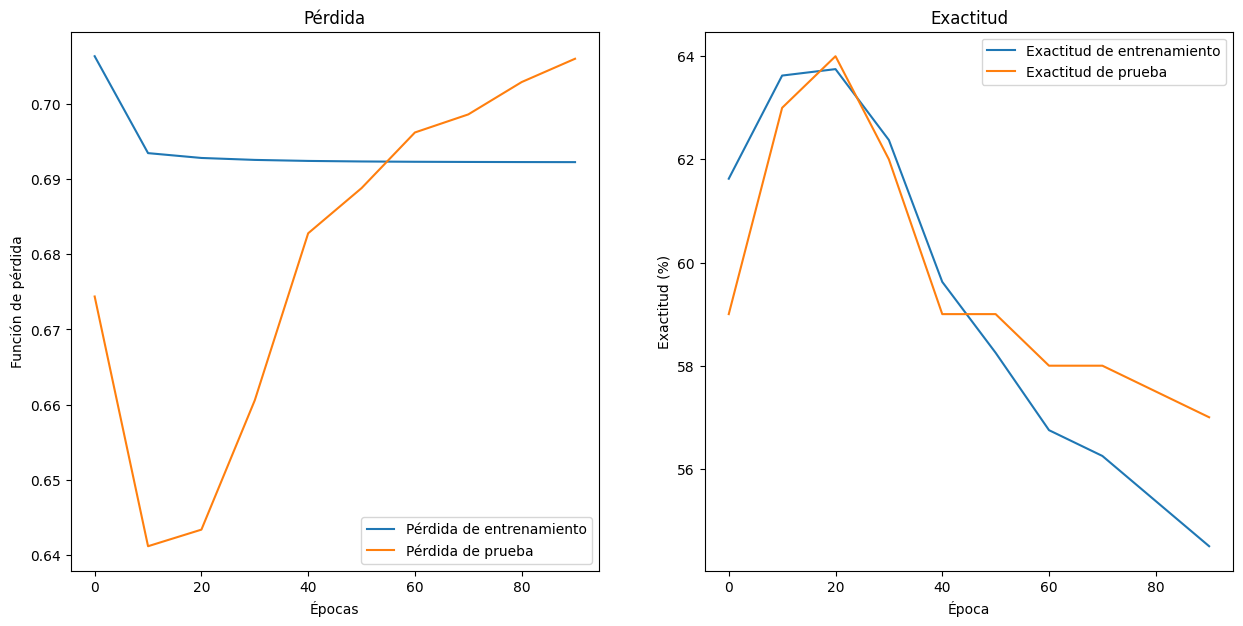

In [14]:
plot_loss_curves(results)


Ahora, procederemos a representar la *frontera de decisión* generada por nuestra red neuronal. Esta frontera se manifiesta como una curva que delinea las áreas que determinan si un punto pertenece a la clase 0 o a la clase 1. En cierto sentido, esta frontera refleja el conocimiento adquirido por el modelo, ya que si el proceso de aprendizaje fue exitoso, los puntos de cada clase deberían ubicarse en la región correspondiente a su respectiva categoría.

Es importante recordar que los puntos azules están asociados a la clase 0, mientras que los puntos rojos están relacionados con la clase 1. Las regiones de decisión se representan con los mismos colores para una visualización más clara.

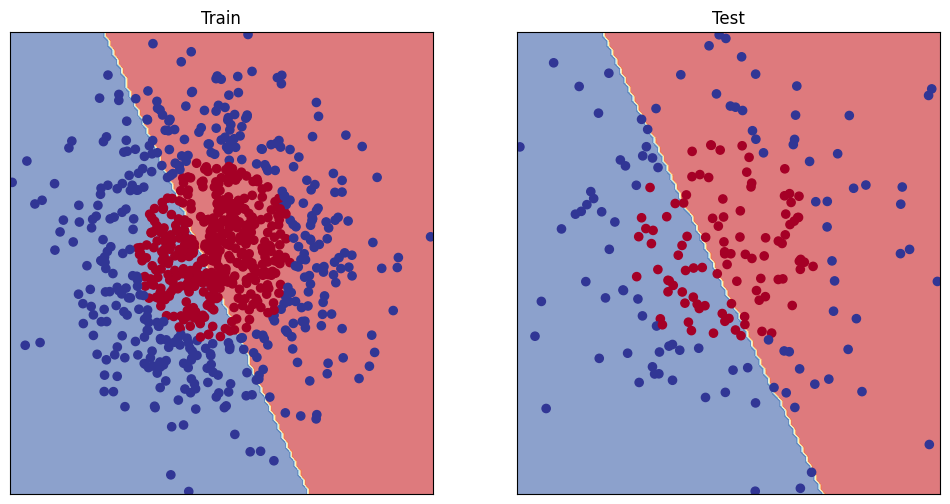

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test, y_test)
plt.show()

Como se aprecia en la figura anterior, nuestro modelo no logró aprender adecuadamente a clasificar ni los datos de entrenamiento ni los datos de prueba. Es evidente que la frontera de decisión que ha aprendido nuestro modelo es una línea recta, esto debido a que cuando implementamos la red, planteamos dos capas ocultas de 3 neuronas que proyectan las características a un espacio 3d como se muestra a continuación:

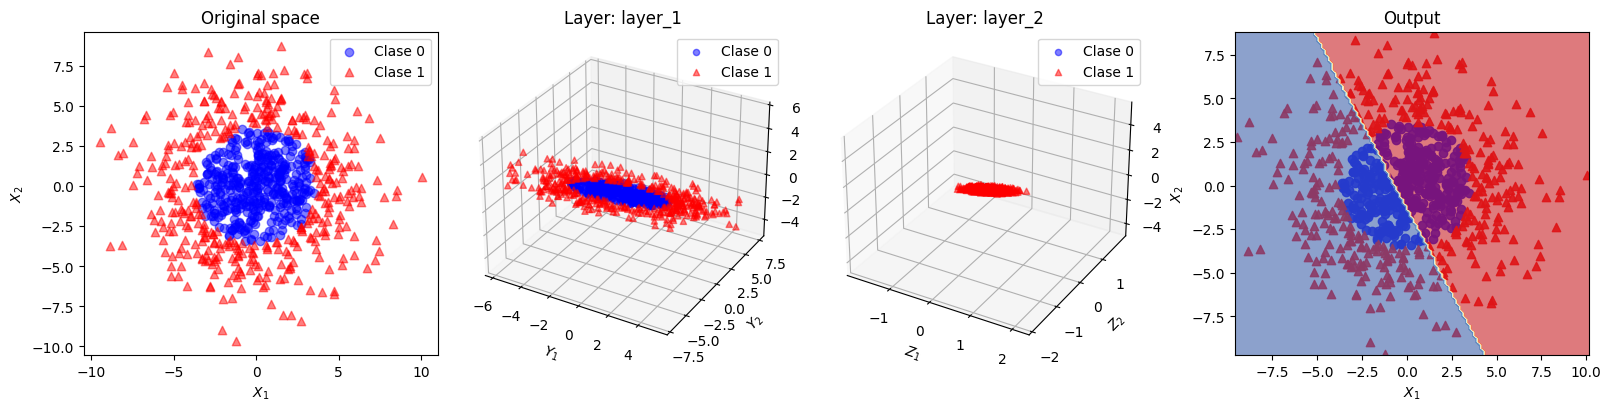

In [16]:
plot_features_space(model_0,X_train,y_train)

Lo anterior conlleva a una alta tasa de errores en la clasificación dado que los datos solo se transforman linealmente. ¿Cómo debería ser, entonces, una frontera de decisión que clasifique correctamente los puntos?

En situaciones prácticas, realizar estas visualizaciones puede ser poco factible, ya que nuestros datos pueden existir en dimensiones mucho más elevadas, o la frontera de decisión puede ser considerablemente más compleja que en este ejemplo. No obstante, siempre tenemos la opción de representar las curvas de entrenamiento. A través de ellas, podemos evaluar cuantitativamente si el modelo ha aprendido correctamente, incluso si no podemos visualizar la frontera de decisión. Si el error en los datos de prueba se aproxima a cero o las métricas de evaluación en los datos de prueba se acercan a uno, podemos concluir que nuestro modelo está realizando una clasificación precisa en datos que no ha visto previamente.¿Qué puede decir sobre las curvas de entrenamiento de nuestro modelo y cómo deberían verse las curvas de entrenamiento de un modelo que logre una clasificación efectiva?

## 4.0 Mejorando la arquitectura de nuestra red

Como hemos observado previamente, aún queda trabajo por hacer para que nuestra red neuronal aprenda a clasificar nuestros datos de manera precisa. En esta sección, nos enfocaremos en mejorar el rendimiento de nuestra red. En la figura anterior, notamos que la frontera de decisión era una línea recta. Un modelo que se limita a trazar fronteras de decisión lineales se conce como un *clasificador lineal*, ya que utiliza una línea para separar los puntos según su posición con respecto a esa línea. Si bien estos clasificadores funcionan eficazmente en ciertos contextos, como hemos comprobado en este caso, cualquier línea que tracemos como frontera de decisión resulta insuficiente para separar nuestros datos de manera adecuada.

Para lograr una clasificación precisa, necesitamos establecer fronteras de decisión más complejas que puedan adaptarse y comprender la geometría de nuestros datos. Para alcanzar este objetivo, introduciremos **funciones de activación no lineales** que permitirán que la frontera de decisión se curve y haga que nuestra red neuronal sea más **expresiva.**

Ahora, vamos a construir una estructura similar a la de nuestra primera red. Mantendremos la misma cantidad de capas y neuronas por capa, pero esta vez emplearemos la función de activación ReLU, abreviatura de "rectified linear unit," en todas las capas ocultas.

Cabe destacar que esta es solo una de las numerosas funciones de activación disponibles en la biblioteca de redes neuronales (nn) de PyTorch. Si desea explorar todas las funciones de activación que ofrece esta biblioteca, puede consultar la documentación en el siguiente enlace: [Documentación de la librería nn de PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [17]:
#Crearemos un segundo modelo que instancia la clase nn de PyTorch (nn de Neural Network)
class ClassifierModelV1(nn.Module):
  def __init__(self):
    #Inicializamos la clase
    super().__init__()
    # Creamos 3 capas donde todas las neuronas tienen función de activación lineal (nn.Linear), las
    #funciones de activación no lineales las vamos a añadir más adelante.
    #Note que el tamaño de la primera capa 'in_features' es 2, pues nuestros datos de entrada
    #están en 2 dimensiones. La salida de nuestro modelo tiene dimensión 1, pues queremos resolver
    #un problema de clasificación binaria.

    #La función nn.Sequential crea un objeto secuencial donde la salida de una capa, se convierte
    #en la entrada de la siguiente capa. Esto es importante, pues cada objeto nn.Linear crea
    #una capa de nuestra red con función de activación lineal. La primera capa nn.Linear tiene
    #2 valores de entrada y 3 de salida. Esto significa que nuestra segunda capa tiene 3 neuronas.


    #En este modelo tendremos dos capas ocultas, de 3 neuronas cada una.
    self.layer_1=nn.Linear(in_features=2, out_features=3)
    self.layer_2=nn.Linear(in_features=3,out_features=3)
    self.layer_3=nn.Linear(in_features=3,out_features=1)
    #Definimos la función de activación no lineal que vamos a utilizar. (ReLU)
    self.relu=nn.ReLU()

  #En la función forward vamos a añadir la función de activación no-lineal para las capas ocultas.
  #Note que le aplicamos la función self.relu unicamente a la salida de primera y segunda capa, pues estas
  #son nuestras únicas capas ocultas.
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

#Creamos una instancia de nuestro segundo modelo y le decimos que todo se procese en la GPU.
model_1=ClassifierModelV1().to(device)
model_1

ClassifierModelV1(
  (layer_1): Linear(in_features=2, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=3, bias=True)
  (layer_3): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
)

Ahora, utilizemos la función de pérdida L1 y el mismo optimizador que utilizamos en nuestra red inicial.

In [18]:
#Definimos nuestra función de error L1
loss_fn=nn.L1Loss()

#Definimos nuestro optimizador stochastic gradient descent y fijamos su tasa de aprendizaje
#lr=0.1.
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

## 4.1 Entrenamiento de nuestra red mejorada

Entrenamos nuestra nueva red utilizando la misma metodología de entrenamiento.

In [19]:
#Fijamos una semilla aleatoria para que nuestros resultados sean reproducibles.
torch.manual_seed(0)
torch.cuda.manual_seed(0)
#Por cuántas épocas queremos entrenar.
epochs=100

#Guardamos diferentes valores para luego graficarlos. Guardaremos las épocas
#y la pérdida y precisión de prueba y entrenamiento.
epoch_count=[]
loss_values=[]
test_loss_values=[]
train_acc_values=[]
test_acc_values=[]

#Le decimos que haga los cálculos en la GPU.
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

#Iteramos en cada época.
for epoch in range(epochs):
  #Le decimos al modelo que se ponga en 'modo de entrenamiento'.
  model_1.train()

  #2.Hacemos un paso forwarad.
  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #3. Calculamos la pérdida y la precisión de nuestro modelo para los datos para los que hicimos
  #el paso forward en el paso 2.
  loss=loss_fn(y_logits, y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  #Esta función 'reinicia' los gradientes. Se utiliza cuando estamos entrenando por batches de datos y tenemos
  #memoria limitada. PyTorch per defecto acumula los gradientes de un batch y cuando pasamos de un batch a otro,
  #debemos reiniciar el gradiente.
  optimizer.zero_grad()

  #4. Utilizamos el algoritmo de retropropagación para estimar el gradiente de la pérdida.
  loss.backward()

  #5. Utilizamos el algoritmo de descenso del gradiente estocástico para actualizar los pesos de nuestra
  #red.
  optimizer.step()

  #6. Probamos el modelo con los pesos actualizados en el conjunto de prueba. Guardamos estos valores para irlos
  #graficando y poder evaluar si nuestra red está aprendiendo.

  #Le decimos al modelo que se ponga en 'modo de evaluación'.
  model_1.eval()
  with torch.inference_mode():

    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    #Calculamos la pérdida y la precisión en el conjunto de prueba
    test_loss=loss_fn(test_pred, y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)


#Vamos a guardar los resultados cada 10 épocas para luego graficarlos.
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
#Guardamos los resultados del entrenamiento para luego graficarlos.
results={"train_loss": loss_values,
             "train_acc": train_acc_values,
             "test_loss": test_loss_values,
             "test_acc":test_acc_values}


## 4.2 Validación de nuestra red mejorada

Ahora, visualizamos las curvas de entrenamiento para nuestro segundo modelo. Note que ahora, las curvas de pérdida de entrenamiento y de prueba están decrececiendo. Es decir, nuestro error de clasificación está disminuyendo a medida que entrenamos nuestra red. Observe también que nuestras curvas de exactitud están aumentando y se acercan cada vez más a 1. Es decir, nuestra exactitud de clasificación está mejorando a medida que entrenamos ¿Cómo se comparan estas curvas con las obtenidas en nuestro primer modelo?

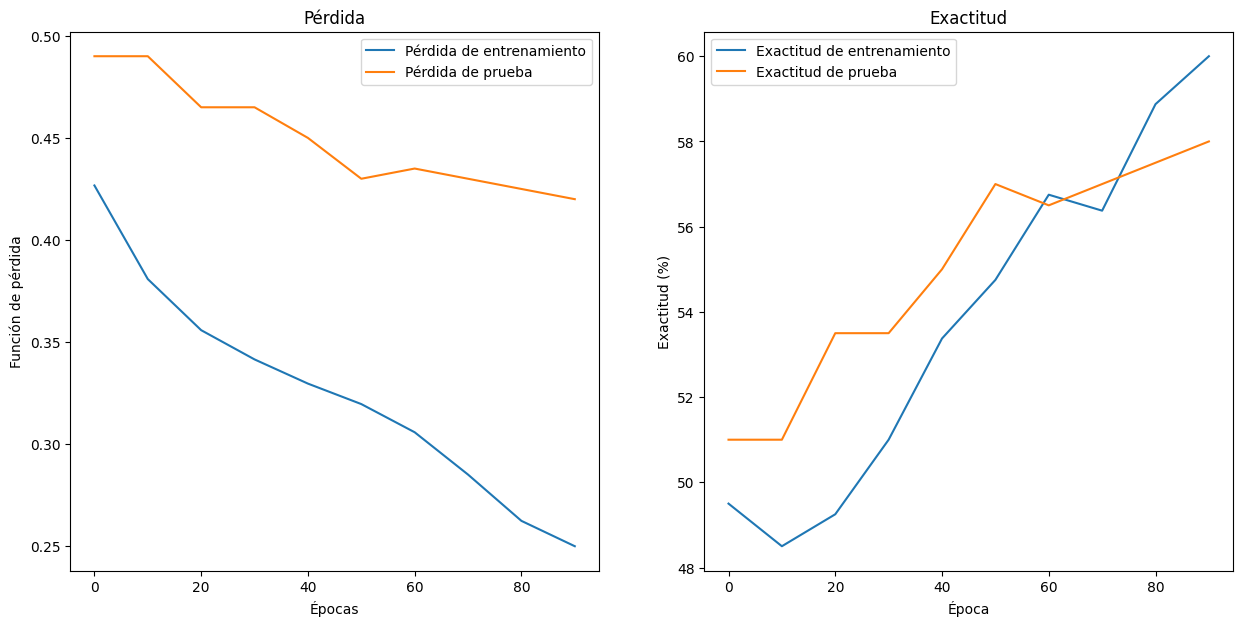

In [20]:
plot_loss_curves(results)

Ahora, presentamos la frontera de decisión que ha sido aprendida por nuestra segunda red neuronal. Es evidente que esta frontera de decisión es más compleja que la anterior y ya no se limita a ser lineal. Tal como se evidenció en las curvas de aprendizaje, estamos logrando una clasificación más efectiva a medida que avanzamos en el entrenamiento.

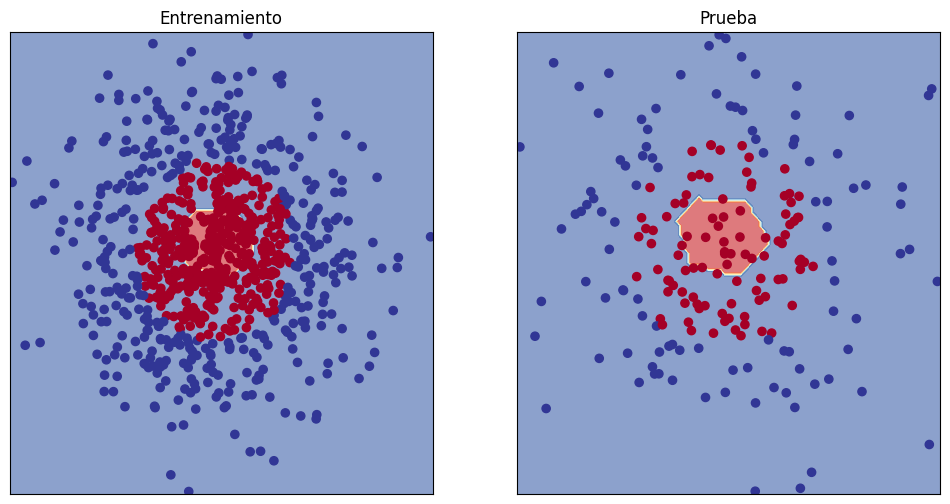

In [21]:
#Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Entrenamiento')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Prueba')
plot_decision_boundary(model_1,X_test, y_test)
plt.show()

Esta frontera de clasificación presenta mejoras ya que el incluir funciones de activación no lineales nos lleva a una mejor separación del espacio, como se presenta a continuación:

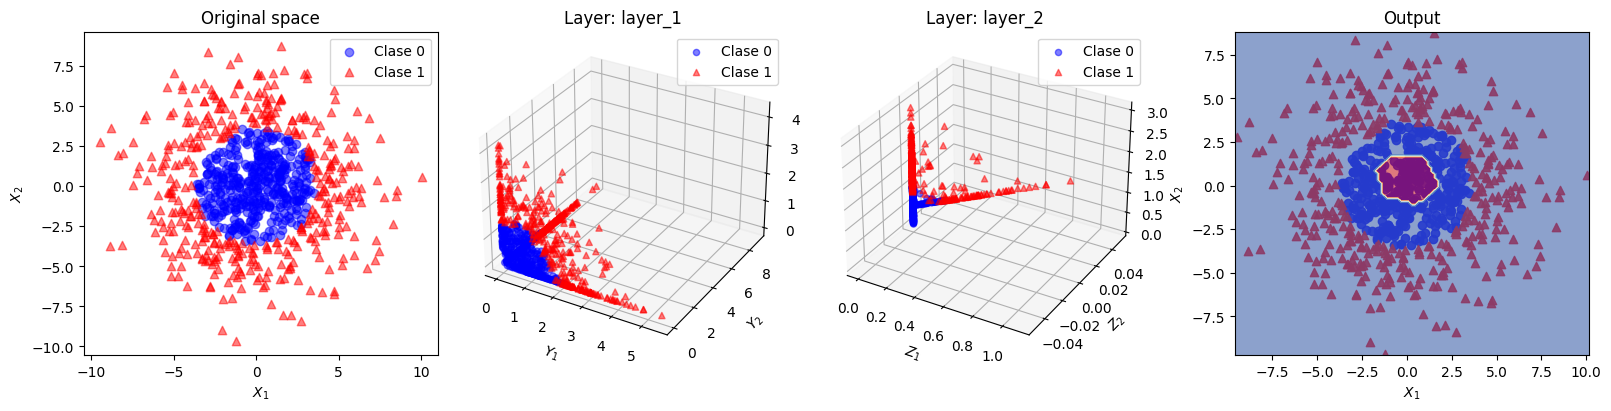

In [22]:
plot_features_space(model_1,X_train,y_train)

 No obstante, aún no hemos alcanzado el nivel de un clasificador sobresaliente, ya que nuestra precisión en los datos de prueba sigue siendo inferior al 60%. Esto significa que nuestro clasificador comete errores en al menos el 40% de las muestras que intenta clasificar.



Si observamos la figura de la frontera de decisión, se hace evidente que esta no separa de manera adecuada las regiones que contienen puntos rojos de aquellas que contienen puntos azules. En el próximo laboratorio, se le presentará el desafío de mejorar aún más la capacidad predictiva de nuestra red neuronal, experimentando con diferentes hiperparámetros del modelo.

Veamos qué tan alta fue la precisión de nuestro modelo en el conjunto de prueba:

In [23]:
print(f'La precisión en el conjunto de prueba para nuestro modelo mejorado es del: {final_test_accuracy(results)} %')

La precisión en el conjunto de prueba para nuestro modelo mejorado es del: 58.0 %


**IMPORTANTE** Para finalizar el laboratorio y verificar que llegaste hasta el final reporta el valor alcanzado por el modelo en la **precisión con el conjunto de prueba**, usa solo dos decimales. Este valor debe quedar en la variable accTest, por favor no renombres la variable. Ejemplo, si la precisión fue del 75.3% ingresa el valor 75.30. **No se aceptarán otros formatos o nomeclaturas.**

In [24]:
accTest = 58.00